In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import copy

from math import floor, ceil
from skimage.color import rgb2gray

import warnings
warnings.filterwarnings("ignore")

In [2]:
def bilinear_interpolate_1(img, pixel):
    """
    Bilinear Interpolation
    
    Parameters:
        img(matrix) - initial unchanged image
        pixel(tuple or list of 2 elements)
        
    Return:
        float(interpolated value)
    """
    
    H, W = img.shape
    x = np.asarray(pixel[0])
    y = np.asarray(pixel[1])
    
    x_0 = np.floor(x).astype(int)
    x_1 = x_0 + 1
    y_0 = np.floor(y).astype(int)
    y_1 = y_0 + 1
    
    x_0 = np.clip(x_0, 0, H - 1)
    x_1 = np.clip(x_1, 0, H - 1)
    y_0 = np.clip(y_0, 0, W - 1)
    y_1 = np.clip(y_1, 0, W - 1)
    
    a_0 = img[ x_0, y_0 ]
    a_1 = img[ x_0, y_1 ]
    a_2 = img[ x_1, y_0 ]
    a_3 = img[ x_1, y_1 ]
    
    w_a_0 = (x - x_0) * (y - y_0)
    w_a_1 = (x - x_0) * (y_1 - y)
    w_a_2 = (x_1 - x) * (y - y_0)
    w_a_3 = (x_1 - x) * (y_1 - y)
    
    return w_a_0 * a_3 + w_a_1 * a_2 + w_a_2 * a_1 + w_a_3 * a_0

In [3]:
def bilinear_interpolate_2(img, pixel):
    """
    Bilinear Interpolation with 2 sequential 1 dimensional interpolation.
    
    Parameters:
        img(matrix) - initial unchanged image
        pixel(tuple or list of 2 elements)
        
    Return:
        float(interpolated value)
    """
    
    H, W = img.shape
    x = np.asarray(pixel[0])
    y = np.asarray(pixel[1])
    
    x_0 = np.floor(x).astype(int)
    x_1 = x_0 + 1
    y_0 = np.floor(y).astype(int)
    y_1 = y_0 + 1
    
    x_0 = np.clip(x_0, 0, H - 1)
    x_1 = np.clip(x_1, 0, H - 1)
    y_0 = np.clip(y_0, 0, W - 1)
    y_1 = np.clip(y_1, 0, W - 1)
    
    f_q_1_1 = img[ x_0, y_0 ]
    f_q_1_2 = img[ x_0, y_1 ]
    f_q_2_1 = img[ x_1, y_0 ]
    f_q_2_2 = img[ x_1, y_1 ]
    
    p_x_y_1 = f_q_1_1 * (x-x_1) / (x_0-x_1) + f_q_2_1 * (x-x_0) / (x_1-x_0)
    p_x_y_2 = f_q_1_2 * (x-x_1) / (x_0-x_1) + f_q_2_2 * (x-x_0) / (x_1-x_0)
    
    return p_x_y_1 * (y-y_1) / (y_0-y_1) + p_x_y_2 * (y-y_0) / (y_1-y_0)

In [4]:
def Sampling(initial_img, i, j, for_center=False):
    """
    Uniform Sampling
    
    Parameters:
        initial_img(matrix) - initial unchanged image
        i(int) -  i-th index
        j(int) - j-th index
        
    Returns:
        list(of floats) - sampled pixel
    """
    
    H = initial_img.shape[0]
    W = initial_img.shape[1]
    if for_center:
        return (i/H + 1/(2*H), j/W + 1/(2*W), 1)
    return (i/H + 1/(2*H), j/W + 1/(2*W))

def Rotation_Matrix(angle):
    """
    Rotation matrix 
    
    Parameters:
        angle (angle in radians)
        
    Returns:
        matrix (A_{theta}^{thilda} inverse)
    """
    
    A_theta = np.array(
        [
            [np.cos(angle), -np.sin(angle), 0], 
            [np.sin(angle),  np.cos(angle), 0], 
            [0, 0, 1]
        ])
    A_theta_thilda = A_theta[:-1, :-1]
    A_theta_thilda_inverse = np.linalg.inv(A_theta_thilda)
    return A_theta_thilda_inverse

def Rotation_Matrix_Center(x, y, angle):
    """
    Rotation Matrix with Centers
    
    Parameters:
        x(int) - x coordinate
        y(int) - y coordinate
        angle(float) - angle with radians
        
    Returns:
        matrix(transformed matrix)
    """
    move_matrix = np.array(
        [
            [1, 0, x], 
            [0, 1, y], 
            [0, 0, 1]
        ])
    rotation_matrix = np.array(
        [
            [np.cos(angle), -np.sin(angle), 0], 
            [np.sin(angle),  np.cos(angle), 0], 
            [0, 0, 1]
        ])
    back_matrix = np.array(
        [
            [1, 0, -x],
            [0, 1, -y],
            [0, 0, 1]
        ])

    r = np.dot(move_matrix, rotation_matrix)
    return np.dot(r, back_matrix)

def Rotation(rotation_matrix, sample, H, W, for_center = False):
    """
    Matrix rotation
    
    Parameters:
        rotation_matrix(matrix) - the output from Rotation_Matrix function
        sample(pixel) - the output from Sampling function
        H(int) - the height of image
        W(int) - the width of image 
    
    Returns:
        tuple of floats (transformed pixel)
    """
    if for_center:
        return np.multiply([H, W, 1], np.dot(rotation_matrix, sample))
    return np.multiply([H, W], np.dot(rotation_matrix, sample))

def Image_Rotation(initial_img, rotation_angle):
    """
    Image Rotation
    
    Parameters:
        initial_img(matrix) - initial unchanged image
        rotation_angle(float) - angle ith radians
        
    Returns:
        matrix(rotated image)
    """
    
    x_max = initial_img.shape[0]
    y_max = initial_img.shape[1]

    new_image = np.zeros((x_max, y_max), dtype=float)

    for y in range(0, y_max):
        for x in range(0, x_max):
            pixel = Rotation(Rotation_Matrix(rotation_angle), Sampling(initial_img, x, y), x_max, y_max)
            new_image[x][y] = bilinear_interpolate_1(initial_img, pixel)
    return new_image

def Image_Rotation_Center(initial_img, rotation_angle):
    """
    Image Rotation by center
    
    Parameters:
        initial_img(matrix) - initial unchanged image
        rotation_angle(float) - angle ith radians
        
    Returns:
        matrix(rotated image)
    """
    
    x_max = initial_img.shape[0]
    y_max = initial_img.shape[1]

    new_image = np.zeros((x_max, y_max), dtype=float)
    
    rotation_matrix_center = np.linalg.inv(Rotation_Matrix_Center(x_max/2, y_max/2, rotation_angle))

    for y in range(0, y_max):
        for x in range(0, x_max):
            pixel = [x, y, 1]

            pixel = np.dot(rotation_matrix_center, pixel)

            new_image[x][y] = bilinear_interpolate_1(initial_img, pixel)

    return new_image

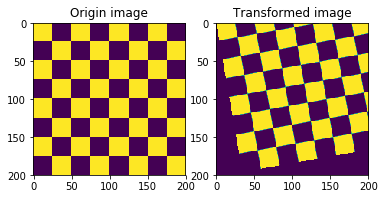

In [5]:
img=mpimg.imread('inputs/20190912/1.png')

plt.subplot(1,2,1)
plt.title('Origin image')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('Transformed image')

rotation_angle = 10
rotation_angle = np.deg2rad(rotation_angle)

roteated = Image_Rotation(img, rotation_angle)

plt.imshow(roteated)

plt.show();

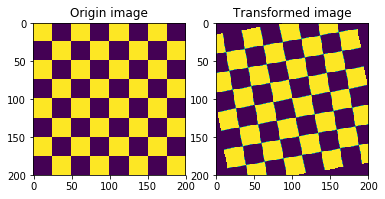

In [6]:
plt.subplot(1,2,1)
plt.title('Origin image')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('Transformed image')

rotation_angle = 10
rotation_angle = np.deg2rad(rotation_angle)

roteated = Image_Rotation_Center(img, rotation_angle)

plt.imshow(roteated)

plt.show();